# Credit Card Loan Applications

## Table of Contents
1. [Introduction and Business Problem](#intro)  
2. [Initial Import of Dataset and Necessary Libraries](#init)  
3. [Statistical Analyses](#stats)  
4. [Data Visualization](#data_viz)
5. [Binary Classification Problem](#bin)  
    a. [Test-Train Split](#bin_tt)  
    b. [Data Pre-Processing](#bin_pre)  
    c. [Training and Evaluating Models](#bin_train_eval)  
    d. [Hyper-Parameter Optimization](#bin_hpo)  
    e. [Evaluation of Binary Model](#bin_eval)
6. [Multiclass Problem](#multi)  
    a. [Statistical Manipulation](#stats_manip)  
    b. [Test-Train Split](#multi_tt)  
    c. [Data Pre-Processing](#multi_pre)  
    d. [Training and Evaluating Models](#multi_train_eval)  
    e. [Hyper-Parameter Optimization](#multi_hpo)  
    f. [Evaluation of Multiclassification Model](#multi_eval)

## Introduction and Business Problem <a name = intro></a>

The final project for Machine Learning for Business tasked students with identifying a  problem that could be solved or facilitated by using ML techniques. The selected problem and its solution must lead to or inform some tangible decision that can be made by management. Consequently, the current project focuses on credit card loan applications. Specifically, the current project aims to train a model which can determine whether applicants are likely to pay their credit card loans back on time, whether late repayments are likely to eventually lead to full repayments, and, consequently, whether  to offer an applicant a credit card loan based on the expected profit that can be made from industry standard interest rates.


## Initial Import of Dataset and Necessary Libraries  <a name = init></a>

In this first cell, the libraries necessary for the current business problem are imported along with the selected [dataset](https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction). The dataset in question is split into two separate CSV files, one containing client features (property ownership, marital status, annual income, etc.), while the other contains the status of client loan repayments going back several months. The information in the second CSV file will be used as the label for the current business problem. These files are `application_record.csv` and `credit_record.csv`, respectively.  

However, since `credit_record.csv` contains data for several months for each individual client, there are several copies of each client ID number within the table. Furthermore, there are several clients on one CSV file that do not appear in the other. Consequently, a list of unique ID numbers shared across both CSV files is also created and stored in `shared_id_list`.  

Finally, the basic information for both CSV files, along with the total number of unique ID numbers shared across both CSV files, are listed.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
print('TF version ',tf.__version__)
#assert tf.__version__ >= "2.0"

from platform import python_version
print('Python version',python_version())

import matplotlib.pyplot as plt

import os
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder 
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


# Model evaluation und visualization
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve

# Hyperparameter optimization
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

credit_record = pd.read_csv("credit_record.csv")
app_record = pd.read_csv("application_record.csv")
shared_id_list = set(app_record["ID"]).intersection(set(credit_record["ID"]))

print(credit_record.info())
print(app_record.info())
print("Shared IDs: " + str(len(shared_id_list)))

TF version  2.9.1
Python version 3.9.12
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  

In [2]:
credit_record.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [3]:
app_record.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


### Further dataset manipulation

In order to assess the business problem in question, only clients whose information appears in both CSV files can be used. Therefore, new DataFrames are made from both the application data and credit record data, only containing ID numbers that appear across both CSV files.

In [4]:
# Create DataFrames with only shared IDs
shared_credit_record = credit_record[credit_record["ID"].isin(shared_id_list)]
shared_app_record = app_record[app_record["ID"].isin(shared_id_list)]

print(shared_credit_record.info())
print(shared_app_record.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 777715 entries, 92938 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   ID              777715 non-null  int64 
 1   MONTHS_BALANCE  777715 non-null  int64 
 2   STATUS          777715 non-null  object
dtypes: int64(2), object(1)
memory usage: 23.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 434812
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  object 
 2   FLAG_OWN_CAR         36457 non-null  object 
 3   FLAG_OWN_REALTY      36457 non-null  object 
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_EDUCATION_TYPE  36457 non-null  ob

## Statistical Analyses <a name = stats></a>

An initial statistical analysis of the credit record dataset is necessary in order to determine appropriate next steps. In the following two cells, the most recent loan repayment status and the most delayed loan repayment status for each client is found and frequencies are displayed in both numeric, normalized, and graphical formats.  

To improve readability, the definition for the loan repayment status symbol is available in the table below. Status symbols are encoded with the value in square brackets when appropriate.  

| Symbol | Description |
| :---: | :---: |
| C [1] | Loan paid off in full for the month |
| X [0] | No loan for the month |
| 0 [2] | Loan less than 30 days past due |
| 1 [3] | Loan less than 60 days past due |
| 2 [4] | Loan less than 90 days past due |
| 3 [5] | Loan less than 120 days past due |
| 4 [6] | Loan less than 150 days past due |
| 5 [7] | Overdue loans or bad debts, write-offs |

C    17950
X     9669
0     8456
1      276
5       76
2       19
3        6
4        5
Name: STATUS, dtype: int64
C    0.492361
X    0.265217
0    0.231944
1    0.007571
5    0.002085
2    0.000521
3    0.000165
4    0.000137
Name: STATUS, dtype: float64


<AxesSubplot:xlabel='STATUS'>

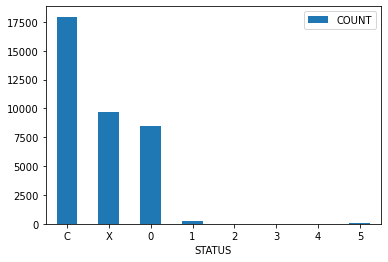

In [5]:
# Most recent loan status for IDs that appear in both tables
shared_credit_record_recent = shared_credit_record.drop_duplicates(subset="ID", ignore_index=True)

print(shared_credit_record_recent["STATUS"].value_counts())
print(shared_credit_record_recent["STATUS"].value_counts(normalize=True))

df = pd.DataFrame({"STATUS":['C', 'X', '0', '1', '2', '3', '4', '5'], "COUNT":[17950, 9669, 8456, 276, 19, 6, 5, 76]})
df.plot.bar(x="STATUS", y="COUNT", rot=0)

**Note: The for loop below takes around 30 to 40 seconds to run**  
As mentioned in the accompanying comment, there is likely a better way to implement this logic, but for the purposes of the current project, the delay is not particularly significant, and the loop outputs the desired result.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 0
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      36457 non-null  object
 1   STATUS  36457 non-null  object
dtypes: object(2)
memory usage: 854.5+ KB
None
2    27711
3     3675
0     3347
1     1108
4      314
7      180
5       76
6       46
Name: STATUS, dtype: int64
2    0.760101
3    0.100804
0    0.091807
1    0.030392
4    0.008613
7    0.004937
5    0.002085
6    0.001262
Name: STATUS, dtype: float64


<AxesSubplot:xlabel='STATUS'>

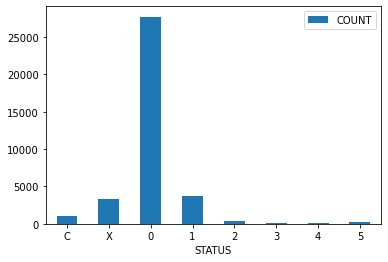

In [6]:
# Create copy of shared_credit_record
shared_credit_record_latest = shared_credit_record.copy()

# Replace objects in STATUS with ints to facilitate comparisons
sym_status = ["5", "4", "3", "2", "1", "0", "C", "X"]
val_status = [7, 6, 5, 4, 3, 2, 1, 0]

for s, v in zip(sym_status, val_status):
    shared_credit_record_latest["STATUS"] = shared_credit_record_latest["STATUS"].replace(to_replace=s, value=v)
    
# Verify replacement occured correctly
#print(shared_credit_record["STATUS"].value_counts())
#print(shared_credit_record_latest["STATUS"].value_counts())

# Find most delayed status for each unique ID
output_df = pd.DataFrame(columns=["ID", "STATUS"])

# There is likely a better way to implement what this for loop is doing, but for the purposes of this project it is sufficient 
# Maybe using the merge and groupby functions?
for ID in shared_id_list:
    delay_df = shared_credit_record_latest.loc[shared_credit_record_latest["ID"] == ID]
    most_delayed = delay_df["STATUS"].max()
    d = {"ID": [ID], "STATUS": [most_delayed]}
    output_df = pd.concat([output_df, pd.DataFrame(data=d)])

print(output_df.info())
print(output_df["STATUS"].value_counts())
print(output_df["STATUS"].value_counts(normalize=True))

df = pd.DataFrame({"STATUS":['C', 'X', '0', '1', '2', '3', '4', '5'], "COUNT":[1108, 3347, 27711, 3675, 314, 76, 46, 180]})
df.plot.bar(x="STATUS", y="COUNT", rot=0)

# Data Visualization <a name = "data_viz"></a>
## Most Recent Credit Data
### Multiclass

In [7]:
shared_credit_record_recent_viz = shared_credit_record_recent.copy()

for s, v in zip(sym_status, val_status):
    shared_credit_record_recent_viz["STATUS"].replace(to_replace=s, value=v, inplace=True)

combined_recent = shared_app_record.merge(shared_credit_record_recent_viz, on="ID")
print(combined_recent.info())
combined_recent.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  object 
 2   FLAG_OWN_CAR         36457 non-null  object 
 3   FLAG_OWN_REALTY      36457 non-null  object 
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_EDUCATION_TYPE  36457 non-null  object 
 8   NAME_FAMILY_STATUS   36457 non-null  object 
 9   NAME_HOUSING_TYPE    36457 non-null  object 
 10  DAYS_BIRTH           36457 non-null  int64  
 11  DAYS_EMPLOYED        36457 non-null  int64  
 12  FLAG_MOBIL           36457 non-null  int64  
 13  FLAG_WORK_PHONE      36457 non-null  int64  
 14  FLAG_PHONE           36457 non-null  int64  
 15  FLAG_EMAIL           36457 non-null 

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0,1
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0,2
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-22,0


<AxesSubplot:xlabel='STATUS', ylabel='AMT_INCOME_TOTAL'>

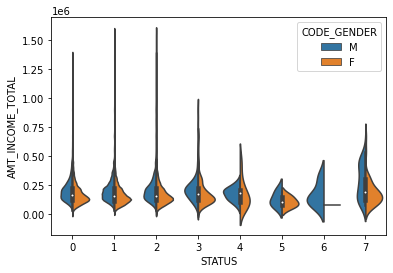

In [8]:
sns.violinplot(x="STATUS", y="AMT_INCOME_TOTAL", hue="CODE_GENDER", split=True, data=combined_recent)

<AxesSubplot:xlabel='STATUS', ylabel='AMT_INCOME_TOTAL'>

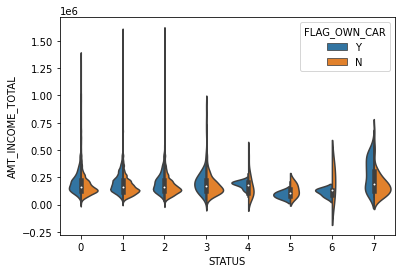

In [9]:
sns.violinplot(x="STATUS", y="AMT_INCOME_TOTAL", hue="FLAG_OWN_CAR", split=True, data=combined_recent)

<AxesSubplot:xlabel='STATUS', ylabel='AMT_INCOME_TOTAL'>

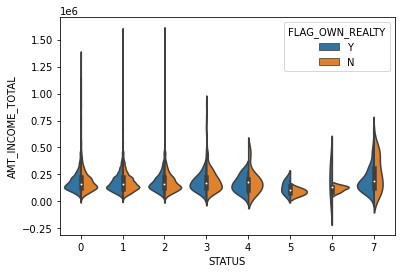

In [10]:
sns.violinplot(x="STATUS", y="AMT_INCOME_TOTAL", hue="FLAG_OWN_REALTY", split=True, data=combined_recent)

### Binary

In [11]:
combined_recent.loc[combined_recent["STATUS"] <= 3, ["STATUS"]] = 0

combined_recent.loc[combined_recent["STATUS"] > 0, ["STATUS"]] = 1

<AxesSubplot:xlabel='STATUS', ylabel='AMT_INCOME_TOTAL'>

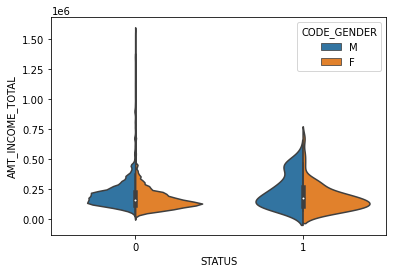

In [12]:
sns.violinplot(x="STATUS", y="AMT_INCOME_TOTAL", hue="CODE_GENDER", split=True, data=combined_recent)

<AxesSubplot:xlabel='STATUS', ylabel='AMT_INCOME_TOTAL'>

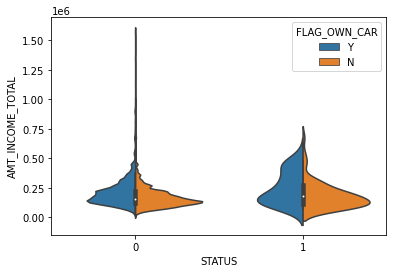

In [13]:
sns.violinplot(x="STATUS", y="AMT_INCOME_TOTAL", hue="FLAG_OWN_CAR", split=True, data=combined_recent)

<AxesSubplot:xlabel='STATUS', ylabel='AMT_INCOME_TOTAL'>

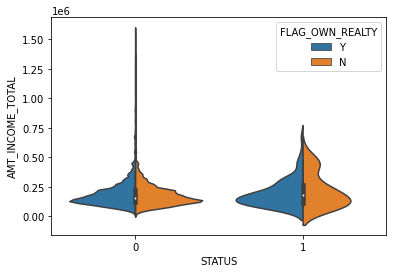

In [14]:
sns.violinplot(x="STATUS", y="AMT_INCOME_TOTAL", hue="FLAG_OWN_REALTY", split=True, data=combined_recent)

## Most Delayed Credit Data
### Multiclass

In [15]:
combined_latest = shared_app_record.merge(output_df, on="ID")

print(combined_latest.info())
combined_latest.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  object 
 1   CODE_GENDER          36457 non-null  object 
 2   FLAG_OWN_CAR         36457 non-null  object 
 3   FLAG_OWN_REALTY      36457 non-null  object 
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_EDUCATION_TYPE  36457 non-null  object 
 8   NAME_FAMILY_STATUS   36457 non-null  object 
 9   NAME_HOUSING_TYPE    36457 non-null  object 
 10  DAYS_BIRTH           36457 non-null  int64  
 11  DAYS_EMPLOYED        36457 non-null  int64  
 12  FLAG_MOBIL           36457 non-null  int64  
 13  FLAG_WORK_PHONE      36457 non-null  int64  
 14  FLAG_PHONE           36457 non-null  int64  
 15  FLAG_EMAIL           36457 non-null 

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,3
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,3
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,2
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,2
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0


<AxesSubplot:xlabel='STATUS', ylabel='AMT_INCOME_TOTAL'>

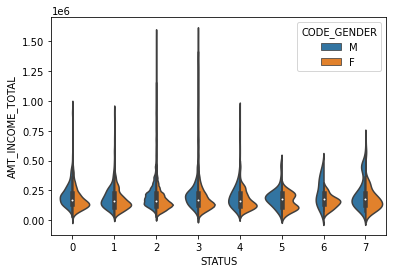

In [16]:
sns.violinplot(x="STATUS", y="AMT_INCOME_TOTAL", hue="CODE_GENDER", split=True, data=combined_latest)

<AxesSubplot:xlabel='STATUS', ylabel='AMT_INCOME_TOTAL'>

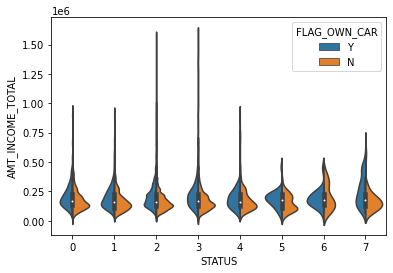

In [17]:
sns.violinplot(x="STATUS", y="AMT_INCOME_TOTAL", hue="FLAG_OWN_CAR", split=True, data=combined_latest)

<AxesSubplot:xlabel='STATUS', ylabel='AMT_INCOME_TOTAL'>

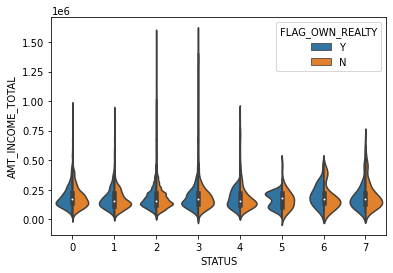

In [18]:
sns.violinplot(x="STATUS", y="AMT_INCOME_TOTAL", hue="FLAG_OWN_REALTY", split=True, data=combined_latest)

### Binary

In [19]:
combined_latest.loc[combined_latest["STATUS"] <= 3, ["STATUS"]] = 0

combined_latest.loc[combined_latest["STATUS"] > 0, ["STATUS"]] = 1

<AxesSubplot:xlabel='STATUS', ylabel='AMT_INCOME_TOTAL'>

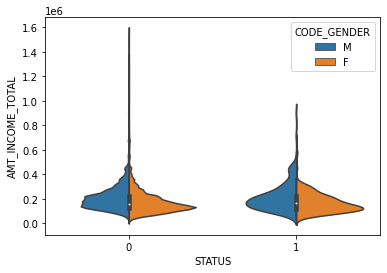

In [20]:
sns.violinplot(x="STATUS", y="AMT_INCOME_TOTAL", hue="CODE_GENDER", split=True, data=combined_latest)

<AxesSubplot:xlabel='STATUS', ylabel='AMT_INCOME_TOTAL'>

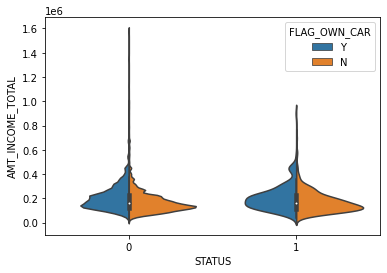

In [21]:
sns.violinplot(x="STATUS", y="AMT_INCOME_TOTAL", hue="FLAG_OWN_CAR", split=True, data=combined_latest)

<AxesSubplot:xlabel='STATUS', ylabel='AMT_INCOME_TOTAL'>

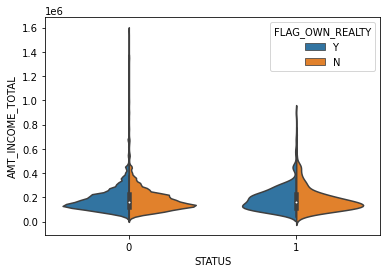

In [22]:
sns.violinplot(x="STATUS", y="AMT_INCOME_TOTAL", hue="FLAG_OWN_REALTY", split=True, data=combined_latest)

# Binary Classification Problem <a name = bin></a>
The first step in addressing the business question is to train a binary classification model to distinguish between "good" applicants and "bad" applicants. For the purpose of the current project, good applicants were classified as individuals who had never been more than two months late on loan repayments. This cutoff point was determined based on two main factors. Initially, the cutoff for good applicants was planned to be at three months, as [consumer credit default is commonly defined as delinquency beyond a period of 90 days](https://www.sciencedirect.com/science/article/abs/pii/S0939362518302875). However, based on the observed distribution of the data, the two-month cutoff was selected due to the small number of defaults present in the database according to the three-month definition cited above.  

## Test-Train Split <a name = bin_tt></a>
In order to train a model using, the available data must be split into testing and training data. In the current example, the relative sizes of these sets were determined to be 80% and 20% of the available data, respectively.  

Prior to performing the split, however, the application record data must be merged with the credit record data into a single DataFrame. This was done using the `shared_app_record` DataFrame and the `output_df` DataFrame, as the current task requires an investigation of the latest an individual has ever paid back a credit card loan. Following the merge, the `"ID"` column is dropped from the DataFrame, as it holds no relevant financial information. Next, the `"STATUS"` column is edited to reflect the binary distinction between good and bad applicants as outlined above. The now binary `"STATUS"` column is copied into the `binary_label` variable and dropped from the `binary_features` variable. These are then used as function inputs for `train_test_split()`, which randomly assigns their entries to either training or testing data.

In [23]:
# Combine application record with most delayed repayment using ID numbers
combined_binary = shared_app_record.merge(output_df, on="ID")
combined_binary.drop(labels="ID", axis=1, inplace=True)

# Clients with maximum repayment delays of less than two months (enconded as the int 3) are considered good
combined_binary.loc[combined_binary["STATUS"] <= 3, ["STATUS"]] = 0

# Clients with maximum repayment delays of more than two months (all those that weren't encoded in the previous line) 
# are considered bad
combined_binary.loc[combined_binary["STATUS"] > 0, ["STATUS"]] = 1

# Create a copy of the most delayed repayment for each unique ID
binary_label = combined_binary["STATUS"].copy()

# Remove each individual's status to hide from training models
binary_features = combined_binary.drop(labels="STATUS", axis=1)

# Run train_test_split() using the label and feature DataFrames as inputs
binary_features, binary_features_test, binary_label, binary_label_test = train_test_split(binary_features, binary_label, 
                                                                                          test_size=0.2, random_state=42)

# Verify train_test_split worked as intended
print(binary_features.shape)
print(binary_features_test.shape)
print(binary_label.shape)
print(binary_label_test.shape)

(29165, 17)
(7292, 17)
(29165,)
(7292,)


**Note: We know the test-train split worked as intended since the dimensionality of both features sets and both label sets are equivalent. Furthermore, the number of entries in both test sets and in both training sets are also seen to be identical.**  
In this case, both feature sets have 17 features, while both label sets are one-dimensional. Both test sets are comprised of 7,292 entries, while both training sets are comprised of 29,165 entries.

## Data Pre-Processing <a name = bin_pre></a>

Following the test-train split, certain subsequent steps must be taken on the training data in order to ensure said data is fit to train a model. These steps can include imputing missing data points, encoding categorical features, and over- or under-sampling the training data.

### Imputing

The first step is to impute any missing data. In this case, only `"OCCUPATION_TYPE"` has any null values. These null values were replaced with `"Unknown"`, as it was determined that an individual's occupation could potentially be an important consideration in certain cases, so it would be inappropriate to drop the feature completely.

In [24]:
binary_features["OCCUPATION_TYPE"].fillna(value="Unknown", inplace=True)
binary_features_test["OCCUPATION_TYPE"].fillna(value="Unknown", inplace=True)

### Encoding

Following imputation, categorical data must be encoded numerically. For certain features, such as the gender of an individual or whether they own property, this task is trivial. However, for other categorical features, a more complex encoding method must be used. In this case, [sklearn's Pipeline function](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) will be used with [One-Hot-Encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

In [25]:
# Encode simple binary categorical features as integers
binary_features["CODE_GENDER"] = binary_features["CODE_GENDER"].map({"M":1, "F":0})
binary_features_test["CODE_GENDER"] = binary_features_test["CODE_GENDER"].map({"M":1, "F":0})
binary_features["FLAG_OWN_CAR"] = binary_features["FLAG_OWN_CAR"].map({"Y":1, "N":0})
binary_features_test["FLAG_OWN_CAR"] = binary_features_test["FLAG_OWN_CAR"].map({"Y":1, "N":0})
binary_features["FLAG_OWN_REALTY"] = binary_features["FLAG_OWN_REALTY"].map({"Y":1, "N":0})
binary_features_test["FLAG_OWN_REALTY"] = binary_features_test["FLAG_OWN_REALTY"].map({"Y":1, "N":0})

# Check which categorical features still need to be encoded
#print(binary_features.info())

# Create a list of remaining categorical features
cat_feature_names = binary_features.select_dtypes(exclude=["int64", "float64"])
cat_feature_names = cat_feature_names.keys()
#for i in cat_feature_names:
#    print(i)

In [26]:
# This class is required for sklearn's Pipeline function to work correctly
# The code for the class and its member functions was taken from class materials
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.attribute_names = feature_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [27]:
pipeline = Pipeline([('selector', DataFrameSelector(cat_feature_names)),
                     ('cat_encoder', OneHotEncoder(drop="first", sparse=False)),])

binary_features_piped = pipeline.fit_transform(binary_features)

print(binary_features_piped.shape)

(29165, 35)


### Over-Sampling

Due to the uneven distribution of data, as apparent in the output of cell 6, the training data must over-sample minority class data. To do this, random entries which fall into the bad applicant category will be made so that the distribution of the training data is sufficient to effectively train the models. In this case, the [SMOTE().fit_resample() function](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html#imblearn.over_sampling.SMOTE.fit_resample) was used. SMOTE was used over random over-sampling to minimize the chances the resultant models will overfit the training data.

In [28]:
from imblearn.over_sampling import SMOTE

print("Size before over-sampling:")
print(binary_features_piped.shape)
print(binary_label.shape)

binary_label = binary_label.astype("int")

binary_features_oversampled, binary_label_oversampled = SMOTE().fit_resample(binary_features_piped, binary_label)

print("Size after over-sampling:")
print(binary_features_oversampled.shape)
print(binary_label_oversampled.shape)

print("Oversampled portion:")
print(sum(binary_label_oversampled)/len(binary_label_oversampled))

Size before over-sampling:
(29165, 35)
(29165,)
Size after over-sampling:
(57332, 35)
(57332,)
Oversampled portion:
0.5


## Training and Evaluating Models <a name = bin_train_eval></a>

For the current binary classification problem, three models will be trained and evaluated. These are as follows:
   - [Logistic Regression](#bin_log)
   - [Random Forest](#bin_randf)
   - [Support Vector Machine](#bin_svm)  

More detail on why each type of model was selected can be found in their respective sections.  

### Logistic Regression <a name = bin_log></a>

[Logistic regression models](https://www.ibm.com/topics/logistic-regression) are one of the more basic machine learning models and are well suited to problems of binary distinction. Due to the simplicity of logistic regression models, the coefficients generated by these models are more easily understood by humans. This is a benefit of using these types of models, as it becomes easier to explain why certain decisions are being made by the algorithm. For the current business problem, where individuals are being denied credit card loans, this interpretability and explainability is an important consideration.

In [29]:
logistic_regression = LogisticRegression(random_state=42, max_iter=1000)
logistic_regression.fit(binary_features_oversampled, binary_label_oversampled)

LogisticRegression(max_iter=1000, random_state=42)

In [30]:
predictions = logistic_regression.predict(binary_features_oversampled)

accuracy = accuracy_score(binary_label_oversampled, predictions)
mse = mean_squared_error(binary_label_oversampled, predictions)
rmse = np.sqrt(mse)

print("Mean Squared Error: ", rmse)
print("Accuracy: ", accuracy)

Mean Squared Error:  0.6637839135834677
Accuracy:  0.5593909160678155


**Note: The larger the accuracy, the better the prediction (to a maximum of 1). The smaller the MSE, the better the prediction (to a minimum of 0).**  
The accuracy is the proportion of predictions that were made correctly. The MSE is the average squared difference between the estimated values and the actual value.

Below, the optimized coefficients for all selected features can be found.

In [31]:
num_feature_names = binary_features.select_dtypes(include=["int64", "float64"])
num_feature_names = num_feature_names.keys()

coefs = logistic_regression.coef_[0]
for (a,c) in zip(num_feature_names,coefs):
    print('%8s: %5.4f' % (a,c) )

CODE_GENDER: 0.2760
FLAG_OWN_CAR: -0.6682
FLAG_OWN_REALTY: -1.5560
CNT_CHILDREN: 0.0453
AMT_INCOME_TOTAL: 1.3205
DAYS_BIRTH: 1.3130
DAYS_EMPLOYED: 1.3101
FLAG_MOBIL: 1.2358
FLAG_WORK_PHONE: 0.0419
FLAG_PHONE: -0.2134
FLAG_EMAIL: 0.3257
CNT_FAM_MEMBERS: 0.5750


In [32]:
first = 13
for i in cat_feature_names:
    coefs = logistic_regression.coef_[0][first:]
    print("%15s:" % (i))
    cat = binary_features[i].value_counts()
    print("    Default Category: ", cat.index[0])
    cat.drop(cat.index[0], inplace=True)
    for (ji,c) in zip(cat.index, coefs):
        print('    %15s: %5.4f' % (ji, c) )
        first += 1

NAME_INCOME_TYPE:
    Default Category:  Working
    Commercial associate: 0.9011
          Pensioner: 0.9222
      State servant: 0.1408
            Student: 0.3300
NAME_EDUCATION_TYPE:
    Default Category:  Secondary / secondary special
    Higher education: -1.3654
    Incomplete higher: -1.1016
    Lower secondary: -0.0181
    Academic degree: 0.0231
NAME_FAMILY_STATUS:
    Default Category:  Married
    Single / not married: -1.2676
     Civil marriage: 0.0670
          Separated: 0.6972
              Widow: -0.3198
NAME_HOUSING_TYPE:
    Default Category:  House / apartment
       With parents: 0.5334
    Municipal apartment: -0.3475
    Rented apartment: -0.9559
    Office apartment: -2.7594
    Co-op apartment: -3.1416
OCCUPATION_TYPE:
    Default Category:  Unknown
           Laborers: -0.5589
         Core staff: -0.7329
        Sales staff: -0.4713
           Managers: -0.4366
            Drivers: -1.5414


In [33]:
scores = cross_val_score(logistic_regression, binary_features_oversampled, binary_label_oversampled,
                         scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print('Mean: %5.4f'%scores.mean())
    print('Standard deviation: %5.4f'%scores.std())
    
display_scores(rmse_scores)

Mean: 0.6643
Standard deviation: 0.0061


### Random Forest <a name = bin_randf></a>

[Random Forest models](https://www.ibm.com/cloud/learn/random-forest) are machine learning algorithms which are made up of a ensemble of [decision trees](https://www.ibm.com/topics/decision-trees). The final output of a random forest is determined by the combination of outputs from its constituent decision trees. The constituent decision trees are made of randomly selected features, so random forests are consequently less prone to overfitting than single decision trees are and are also often more accurate. This has contributed to the popularity of this type of model, which also benefits from its ease of use and adaptability to a wide range of problems. However, random forest models are less interpretable and, consequently, less explainable than logistic regression models.

In [34]:
bin_forest = RandomForestClassifier(random_state=42)
bin_forest.fit(binary_features_oversampled, binary_label_oversampled)

RandomForestClassifier(random_state=42)

In [35]:
predictions = bin_forest.predict(binary_features_oversampled)

accuracy = accuracy_score(binary_label_oversampled, predictions)
bin_forest_mse = mean_squared_error(binary_label_oversampled, predictions)
bin_forest_rmse = np.sqrt(bin_forest_mse)

print("Mean Squared Error: ", bin_forest_rmse)
print("Accuracy: ", accuracy)

Mean Squared Error:  0.4915031896886131
Accuracy:  0.7584246145259192


In [36]:
bin_forest_scores = cross_val_score(bin_forest, binary_features_oversampled, binary_label_oversampled,
                                scoring="neg_mean_squared_error", cv=10)
bin_forest_rmse_scores = np.sqrt(-bin_forest_scores)

display_scores(bin_forest_rmse_scores)

Mean: 0.4941
Standard deviation: 0.0100


### Support Vector Machine <a name = bin_svm></a>
[Support Vector Machines](https://scikit-learn.org/stable/modules/svm.html) are machine learning models that are useful for classification and regression problems with a large number of features. They are also versatile, as several different Kernel functions can be specified while training them. However, they are quite slow to train, and usually do not provide significantly better results than other models to justify the much greater time expense.

In [37]:
bin_svm = SVC()
%time bin_svm.fit(binary_features_oversampled, binary_label_oversampled)
predictions = bin_svm.predict(binary_features_oversampled)

accuracy = accuracy_score(binary_label_oversampled, predictions)
bin_svm_mse = mean_squared_error(binary_label_oversampled, predictions)
bin_svm_rmse = np.sqrt(bin_svm_mse)

print("Mean Squared Error: ", bin_svm_rmse)
print("Accuracy: ", accuracy)

CPU times: total: 59.1 s
Wall time: 59.1 s
Mean Squared Error:  0.5158480508924816
Accuracy:  0.7339007883904277


In [38]:
%time bin_svm_scores = cross_val_score(bin_svm, binary_features_oversampled, binary_label_oversampled, scoring="neg_mean_squared_error", cv=5)
bin_svm_rmse_scores = np.sqrt(-bin_svm_scores)
display_scores(bin_svm_rmse_scores)

CPU times: total: 4min 28s
Wall time: 4min 28s
Mean: 0.5210
Standard deviation: 0.0078


## Hyper-Parameter Optimization <a name = "bin_hpo"></a>
The random forest model had the highest accuracy, lowest MSE, and lowest cross-validation mean of all three binary classification models.In order to improve it even further, the model's hyper-parameters must be optimized. This is done through [random search cross-validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) in order to maximize the number of parameters that can be included during optimization without accruing too much of a computational and time expense. The random search function is seeking the random forest with the best [F-1 score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), which places equal weight on the model's precision and its recall.

In [39]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [40]:
bin_random_search = RandomizedSearchCV(estimator=bin_forest, param_distributions=random_grid, n_iter=100, cv=3, 
                                       scoring='f1', n_jobs=-1)
%time bin_random_search.fit(binary_features_oversampled, binary_label_oversampled)

C:\Users\Nathan\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


CPU times: total: 6.81 s
Wall time: 25min 52s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   scoring='f1')

In [41]:
bin_random_search.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 30,
 'bootstrap': False}

In [42]:
bin_random_search.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=30, max_features='auto',
                       min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200, random_state=42)

## Evaluation of Binary Model <a name = "bin_eval"></a>
### Random Forest  

In order to test the actual performance of the optimized random forest model, it must be tested with data the model has not previously seen. In order to do this, the optimized final random forest model is fit to the `binary_features_test` data. Following this, a confusion matrix, ROC curve, and two graphs demonstrating the relationship between precision and recall and generated based on the model's predictions. 

In [43]:
bin_final_rf = bin_random_search.best_estimator_

binary_features_test_prepared = pipeline.fit_transform(binary_features_test)
bin_final_predictions = bin_final_rf.predict(binary_features_test_prepared)

binary_label_test = binary_label_test.astype("int")

accuracy = accuracy_score(binary_label_test, bin_final_predictions)
bin_final_rf_mse = mean_squared_error(binary_label_test, bin_final_predictions)
bin_final_rf_rmse = np.sqrt(bin_final_rf_mse)

print("Mean Squared Error: ", bin_final_rf_rmse)
print("Accuracy: ", accuracy)

Mean Squared Error:  0.42803560789226075
Accuracy:  0.8167855183763028


In [44]:
conf_mat = confusion_matrix(binary_label_test, bin_final_predictions, normalize='all')
print(conf_mat)

[[0.81130005 0.17265496]
 [0.01055952 0.00548546]]


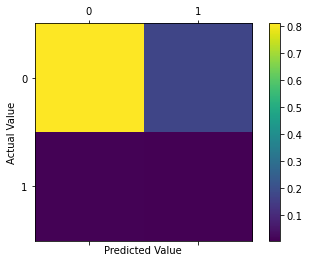

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat)
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
fig.colorbar(cax)

In [46]:
bin_final_rf.probability = True
# New fit, to compute scores:
bin_final_rf.fit(binary_features_oversampled, binary_label_oversampled)

C:\Users\Nathan\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(bootstrap=False, max_depth=30, max_features='auto',
                       min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200, random_state=42)

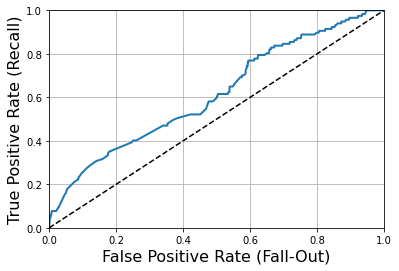

In [47]:
final_predictions_scores = bin_final_rf.predict_proba(binary_features_test_prepared)[:,1]
fpr, tpr, thresholds = roc_curve(binary_label_test, final_predictions_scores)

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
plt.ylabel('True Positive Rate (Recall)', fontsize=16)
plt.grid(True)

In [48]:
print(roc_auc_score(binary_label_test,final_predictions_scores))

0.6141171565561809


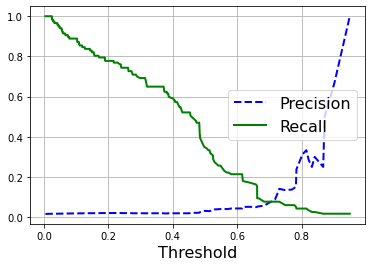

In [49]:
precisions, recalls, thresholds = precision_recall_curve(binary_label_test, final_predictions_scores)

plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.legend(loc="center right", fontsize=16)
plt.xlabel("Threshold", fontsize=16) 
plt.grid(True)

plt.show()

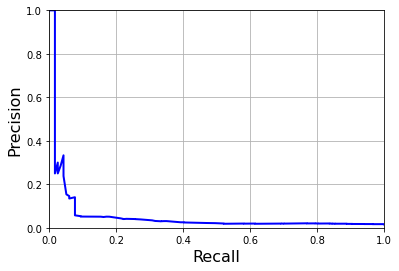

In [50]:
plt.plot(recalls, precisions, "b-", linewidth=2)
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

### Logistic regression
Even though the logistic regression model had the lowest accuracy, it is the most interperable and therefore the most explainable of the three binary classification models. Consequently, it was deemed worthwhile to evaluate it as well.

In [51]:
bin_lr_predictions = logistic_regression.predict(binary_features_test_prepared)

accuracy = accuracy_score(binary_label_test, bin_lr_predictions)
bin_final_rf_mse = mean_squared_error(binary_label_test, bin_final_predictions)
bin_final_rf_rmse = np.sqrt(bin_final_rf_mse)

print("Mean Squared Error: ", bin_final_rf_rmse)
print("Accuracy: ", accuracy)

Mean Squared Error:  0.42803560789226075
Accuracy:  0.5630828304991772


In [52]:
conf_mat = confusion_matrix(binary_label_test, bin_lr_predictions, normalize='all')
print(conf_mat)

[[0.55307186 0.43088316]
 [0.00603401 0.01001097]]


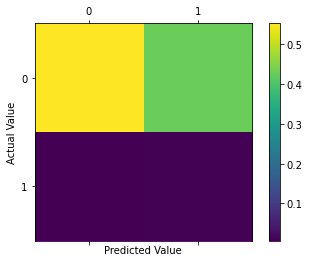

In [53]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat)
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
fig.colorbar(cax)

In [54]:
logistic_regression.probability = True
# New fit, to compute scores:
logistic_regression.fit(binary_features_oversampled, binary_label_oversampled)

LogisticRegression(max_iter=1000, random_state=42)

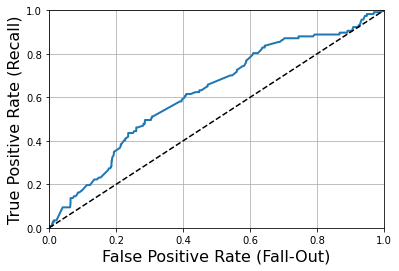

In [55]:
final_predictions_scores = logistic_regression.predict_proba(binary_features_test_prepared)[:,1]
fpr, tpr, thresholds = roc_curve(binary_label_test, final_predictions_scores)

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
plt.ylabel('True Positive Rate (Recall)', fontsize=16)
plt.grid(True)

In [56]:
print(roc_auc_score(binary_label_test,final_predictions_scores))

0.6236028470174811


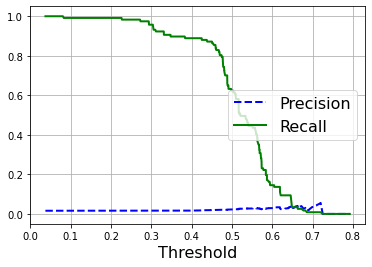

In [57]:
precisions, recalls, thresholds = precision_recall_curve(binary_label_test, final_predictions_scores)

plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.legend(loc="center right", fontsize=16)
plt.xlabel("Threshold", fontsize=16) 
plt.grid(True)

plt.show()

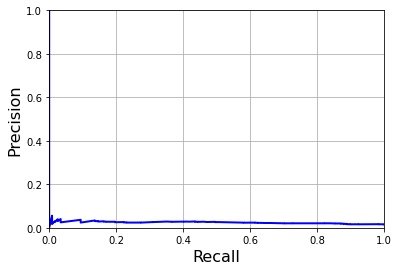

In [58]:
plt.plot(recalls, precisions, "b-", linewidth=2)
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

### Evaluation and Recommendations

From the confusion matrices seen above, the random forest model is much more effective at predicting true negatives (or good applicants) than the logistic regression. Additionally, the overall accuracy of the random forest is significantly higher (82% compared to 56%). However, both models perform poorly when predicting "bad customers". For both the random forest and the logistic regression, the rate of false positives are high, while the rate of true positives are low. Although these results could, in part, be due to the unbalanced nature of the original dataset, they are still less than optimal.  

Potential reasons for this could be that the features are less correlated to the label than initially thought, or are not detailed enough to provide sufficient information to accurately predict the label. For example, an applicant might own a car, but the value of the car might be more significant in determining the probability of default.  

However, the optimized random forest might still be useful. Even though less than 50% of bad applicants (positives) were correctly identified as such, this might still be financially beneficial. Having half the previous number of defaults is likely to be beneficial to any credit card provider. Further analysis would be needed to determine whether this decrease in defaults would be worth the potential decrease in clients who will be able to repay in full.

# Multiclass Problem <a name = "multi"></a>

Following the binary classification problem, a multiclassification model must be designed that assesses how late an applicant will eventually pay their loans back, if at all. This model would be used to guide the decision on what interest rates to assign clients such that the repayments cover the defaults of other clients. In practice, the multiclassification model would be used subsequent to the binary model with the data from the good applicants.   

## Statistical Manipulation  <a name = "stats_manip"></a>
In order to approach this problem, the stastical analysis already performed must be built upon in order to determine the probability that a delayed repayment will eventually result in defaults or full repayments. In order to do this, the data for the latest each client has repayed their loan must be taken and compared to the most recent loan data. Any case where the most recent loan data does not reflect a full repayment, the client will contribute to their latest repayment category's probability of default. 

In [59]:
# Need to encode most recent data numerically (like most delayed)
for s, v in zip(sym_status, val_status):
    shared_credit_record_recent["STATUS"].replace(to_replace=s, value=v, inplace=True)

shared_credit_record_latest = output_df.copy()

default_prob = pd.DataFrame(columns=["STATUS", "DEFAULT_PROB"])

for stat in val_status:
    df = shared_credit_record_latest.loc[shared_credit_record_latest["STATUS"] == stat]
    df = df.merge(shared_credit_record_recent, on="ID")
    default = df.loc[df["STATUS_y"] > 1]
    prob = len(default)/len(df)
    d = {"STATUS": [stat], "DEFAULT_PROB": [prob]}
    default_prob = pd.concat([default_prob, pd.DataFrame(data=d)])

default_prob

C:\Users\Nathan\AppData\Local\Temp\ipykernel_22652\3918316198.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shared_credit_record_recent["STATUS"].replace(to_replace=s, value=v, inplace=True)


,STATUS,DEFAULT_PROB
0,7,0.466667
0,6,0.152174
0,5,0.223684
0,4,0.315287
0,3,0.295238
0,2,0.272311
0,1,0.0
0,0,0.0


## Test-Train Split <a name = "multi_tt"></a>  

Like the binary distinction problem, the data must be split into training and testing data. For the sake of consistency, the 80% training data and 20% testing data ratio will be maintained.

In [60]:
combined_multi = shared_app_record.merge(output_df, on="ID")
combined_multi.drop(labels="ID", axis=1, inplace=True)

multi_label = combined_multi["STATUS"].copy()

# Remove each individual's status to hide from training models
multi_features = combined_multi.drop(labels="STATUS", axis=1)

# Run train_test_split() using the label and feature DataFrames as inputs
multi_features, multi_features_test, multi_label, multi_label_test = train_test_split(multi_features, multi_label, 
                                                                                          test_size=0.2, random_state=42)

# Verify train_test_split worked as intended
print(multi_features.shape)
print(multi_features_test.shape)
print(multi_label.shape)
print(multi_label_test.shape)

(29165, 17)
(7292, 17)
(29165,)
(7292,)


## Data Pre-Processing <a name = "multi_pre"></a>

The data pre-processing for the multiclassification problem will be practicaly identical to the binary classification problem. A notable difference, however, will be that no further encoding of the label will be necessary. Because of this, after oversampling, the size of the features dataset will be significantly larger as 7 categories need to be equivalently represented instead of just 2.  

### Imputing  

In [61]:
multi_features["OCCUPATION_TYPE"].fillna(value="Unknown", inplace=True)
multi_features_test["OCCUPATION_TYPE"].fillna(value="Unknown", inplace=True)

### Encoding  


In [62]:
multi_features["CODE_GENDER"] = multi_features["CODE_GENDER"].map({"M":1, "F":0})
multi_features_test["CODE_GENDER"] = multi_features_test["CODE_GENDER"].map({"M":1, "F":0})
multi_features["FLAG_OWN_CAR"] = multi_features["FLAG_OWN_CAR"].map({"Y":1, "N":0})
multi_features_test["FLAG_OWN_CAR"] = multi_features_test["FLAG_OWN_CAR"].map({"Y":1, "N":0})
multi_features["FLAG_OWN_REALTY"] = multi_features["FLAG_OWN_REALTY"].map({"Y":1, "N":0})
multi_features_test["FLAG_OWN_REALTY"] = multi_features_test["FLAG_OWN_REALTY"].map({"Y":1, "N":0})

In [63]:
multi_features_piped = pipeline.fit_transform(multi_features)

print(multi_features_piped.shape)

(29165, 35)


### Over-Sampling  


In [64]:
print("Size before over-sampling:")
print(multi_features_piped.shape)
print(multi_label.shape)

multi_label = multi_label.astype("int")

multi_features_oversampled, multi_label_oversampled = SMOTE().fit_resample(multi_features_piped, multi_label)

print("Size after over-sampling:")
print(multi_features_oversampled.shape)
print(multi_label_oversampled.shape)

Size before over-sampling:
(29165, 35)
(29165,)
Size after over-sampling:
(177792, 35)
(177792,)


In [65]:
print(multi_label_oversampled.value_counts())
print(multi_label_oversampled.value_counts(normalize=True))

3    22224
2    22224
0    22224
1    22224
7    22224
4    22224
6    22224
5    22224
Name: STATUS, dtype: int64
3    0.125
2    0.125
0    0.125
1    0.125
7    0.125
4    0.125
6    0.125
5    0.125
Name: STATUS, dtype: float64


## Training and Evaluating Models <a name = "multi_train_eval"></a>  

Although this process will be similar to the training and evaluation of the binary model, it will differ slightly in the types of models being used. For the current problem, models that are suited to multiclass distinctions will be used. These are as follows:
   - [Random Forest](#multi_randf)
   - [Support Vector Machine](#multi_svm)
   - [Artificial Neural Network](#multi_ann)  

As above, more specific detail on why each type of model was chosen can be found under their respective sections.  

### Random Forest <a name = "multi_randf"></a>  

In addition to being well suited to binary classification tasks, random forests can also be used to distinguish between multiple classes.

In [66]:
multi_forest = RandomForestClassifier(random_state=42)
multi_forest.fit(multi_features_oversampled, multi_label_oversampled)

RandomForestClassifier(random_state=42)

In [67]:
predictions = multi_forest.predict(multi_features_oversampled)

accuracy = accuracy_score(multi_label_oversampled, predictions)
multi_forest_mse = mean_squared_error(multi_label_oversampled, predictions)
multi_forest_rmse = np.sqrt(multi_forest_mse)

print("Mean Squared Error: ", multi_forest_rmse)
print("Accuracy: ", accuracy)

Mean Squared Error:  1.923463256245918
Accuracy:  0.623172021238301


In [68]:
multi_forest_scores = cross_val_score(multi_forest, multi_features_oversampled, multi_label_oversampled,
                                scoring="neg_mean_squared_error", cv=10)
multi_forest_rmse_scores = np.sqrt(-multi_forest_scores)

display_scores(multi_forest_rmse_scores)

Mean: 2.0179
Standard deviation: 0.0223


### Support Vector Machine <a name = "multi_svm"></a>  

Like random forests, support vector machines are also suitable for use in multiclassification problems. However, due to the much larger size of the oversampled training data, the time cost is likely to be too significant to warrant hyperparameter optimization ansd further usage.

In [69]:
multi_svm = SVC()
%time multi_svm.fit(multi_features_oversampled, multi_label_oversampled)
predictions = multi_svm.predict(multi_features_oversampled)

accuracy = accuracy_score(multi_label_oversampled, predictions)
multi_svm_mse = mean_squared_error(multi_label_oversampled, predictions)
multi_svm_rmse = np.sqrt(multi_svm_mse)

print("Mean Squared Error: ", multi_svm_rmse)
print("Accuracy: ", accuracy)

CPU times: total: 11min 2s
Wall time: 11min 3s
Mean Squared Error:  2.2210308106307437
Accuracy:  0.5219188714902808


In [70]:
%time multi_svm_scores = cross_val_score(multi_svm, multi_features_oversampled, multi_label_oversampled, scoring="neg_mean_squared_error", cv=3)
multi_svm_rmse_scores = np.sqrt(-multi_svm_scores)
display_scores(multi_svm_rmse_scores)

CPU times: total: 41min 36s
Wall time: 42min 9s
Mean: 2.2439
Standard deviation: 0.0031


### Artificial Neural Network <a name = "multi_ann"></a>  

[Artificial neural networks](https://www.ibm.com/cloud/learn/neural-networks) are machine learning models which are inspired by the human brain. They are made up of several layers of interconnected nodes with associated weights and thresholds. These determine whether a node will output a signal and how much the signal impacts the model's final decision. Artificial neural networks can be among the most accurate machine learning models, particularly for complex tasks like computer vision and language processing, but they are difficult to interpret and thus explain. Consequently, for business problems where a model's decision might have a large impact on a customer's life, such as the current one, a more explainable model might be more desirable. 

In [71]:
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%H_%M")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir = run_logdir.replace("\\", "/")
run_logdir

'./my_logs/run_15_13'

In [72]:
ann = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[35]),
    keras.layers.Dense(2000, activation="relu"),
    keras.layers.Dense(1000, activation="relu"),
    keras.layers.Dense(500, activation="relu"),  
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(40, activation="relu"),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(20, activation="relu"),
    keras.layers.Dense(15, activation="relu"),
    keras.layers.Dense(8, activation="softmax")
])

In [73]:
ann.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 35)                0         
                                                                 
 dense (Dense)               (None, 2000)              72000     
                                                                 
 dense_1 (Dense)             (None, 1000)              2001000   
                                                                 
 dense_2 (Dense)             (None, 500)               500500    
                                                                 
 dense_3 (Dense)             (None, 300)               150300    
                                                                 
 dense_4 (Dense)             (None, 100)               30100     
                                                                 
 dense_5 (Dense)             (None, 50)                5

In [74]:
ann.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [77]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

multi_features_oversampled = np.asarray(multi_features_oversampled).astype("float32")
multi_label_oversampled = np.asarray(multi_label_oversampled).astype("float32")

multi_features_test_ann = pipeline.fit_transform(multi_features_test)
multi_features_test_ann = np.asarray(multi_features_test_ann).astype("float32")
multi_label_test_ann = np.asarray(multi_label_test).astype("float32")

multi_ann = ann.fit(multi_features_oversampled, multi_label_oversampled, epochs=50,   
                    validation_data=(multi_features_test_ann, multi_label_test_ann),
                    callbacks=[tensorboard_cb])

Epoch 1/50
5556/5556 [==============================] - 42s 7ms/step - loss: 1.8655 - accuracy: 0.2682 - val_loss: 1.9177 - val_accuracy: 0.2255
Epoch 2/50
5556/5556 [==============================] - 104s 19ms/step - loss: 1.5480 - accuracy: 0.3931 - val_loss: 1.7836 - val_accuracy: 0.2015
Epoch 3/50
5556/5556 [==============================] - 96s 17ms/step - loss: 1.4077 - accuracy: 0.4405 - val_loss: 2.0547 - val_accuracy: 0.0421
Epoch 4/50
5556/5556 [==============================] - 98s 18ms/step - loss: 1.3409 - accuracy: 0.4630 - val_loss: 1.7465 - val_accuracy: 0.0636
Epoch 5/50
5556/5556 [==============================] - 116s 21ms/step - loss: 1.2969 - accuracy: 0.4806 - val_loss: 1.7291 - val_accuracy: 0.0769
Epoch 6/50
5556/5556 [==============================] - 103s 19ms/step - loss: 1.2673 - accuracy: 0.4898 - val_loss: 1.7846 - val_accuracy: 0.0694
Epoch 7/50
5556/5556 [==============================] - 131s 24ms/step - loss: 1.2448 - accuracy: 0.4986 - val_loss: 1.817

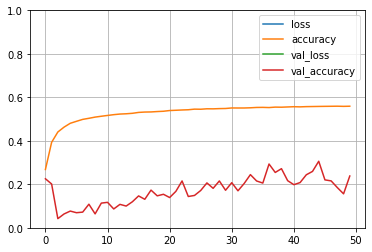

In [78]:
plt.plot(pd.DataFrame(multi_ann.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.legend(multi_ann.history.keys())
plt.show()

In [79]:
%load_ext tensorboard
%tensorboard --logdir {run_logdir}  --host localhost

## Hyper-Parameter Optimization <a name = "multi_hpo"></a> 

### Random Forest  

As with the binary classification problem, the random forest model was shown to be the most accurate in its predictions for the multiclassification problem. However, at only ~62%, its accuracy rating is still quite low. In order to improve this as much as possible, the random forest model's hyper-parameters will be optimized using accuracy scoring.

In [80]:
multi_random_search = RandomizedSearchCV(estimator=multi_forest, param_distributions=random_grid, n_iter=100, cv=3, 
                                       scoring='accuracy', n_jobs=-1)
%time multi_random_search.fit(multi_features_oversampled, multi_label_oversampled)

CPU times: total: 4min 34s
Wall time: 1h 51min 57s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   scoring='accuracy')

In [81]:
multi_random_search.best_params_

{'n_estimators': 1200,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': True}

In [82]:
multi_random_search.best_estimator_

RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=1200,
                       random_state=42)

### Artifical Neural Network  

While the validation accuracy for the artificial neural network was quite low during the initial training period, it is possible that this could be improved throuhg hyper-parameter optimization using [KerasTuner](https://keras.io/keras_tuner/). However, due to the time constraints of the current project, this will be done at a later date.

## Evaluation of Multiclassification Model <a name = "multi_eval"></a>  

Because the neural network has not yet been optimized, the final model evaluation will only focus on the random forest. 

In [84]:
multi_final_rf = multi_random_search.best_estimator_


multi_final_predictions = multi_final_rf.predict(multi_features_test_ann)

multi_label_test = multi_label_test.astype("int")

accuracy = accuracy_score(multi_label_test, multi_final_predictions)
multi_final_rf_mse = mean_squared_error(multi_label_test, multi_final_predictions)
multi_final_rf_rmse = np.sqrt(multi_final_rf_mse)

print("Mean Squared Error: ", multi_final_rf_rmse)
print("Accuracy: ", accuracy)

Mean Squared Error:  2.125808548702774
Accuracy:  0.22860669226549643


In [85]:
conf_mat = confusion_matrix(multi_label_test, multi_final_predictions, normalize='all')
print(conf_mat)

[[2.72901810e-02 8.50246846e-03 1.48107515e-02 1.42622052e-02
  1.46736149e-02 1.11080636e-02 5.48546352e-04 3.01700494e-03]
 [5.34832693e-03 7.95392211e-03 5.34832693e-03 5.21119035e-03
  3.83982447e-03 5.34832693e-03 0.00000000e+00 6.85682940e-04]
 [1.60998354e-01 7.81678552e-02 1.66620954e-01 1.12726275e-01
  9.91497532e-02 1.04086670e-01 1.23422929e-03 2.94843664e-02]
 [2.39989029e-02 9.73669775e-03 1.85134394e-02 2.37246297e-02
  1.34393856e-02 1.04223807e-02 8.22819528e-04 2.87986835e-03]
 [1.23422929e-03 6.85682940e-04 2.33132200e-03 6.85682940e-04
  1.91991223e-03 2.05704882e-03 0.00000000e+00 5.48546352e-04]
 [2.74273176e-04 1.37136588e-04 5.48546352e-04 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 1.37136588e-04]
 [4.11409764e-04 1.37136588e-04 1.37136588e-04 0.00000000e+00
  2.74273176e-04 1.37136588e-04 6.85682940e-04 0.00000000e+00]
 [6.85682940e-04 5.48546352e-04 4.11409764e-04 5.48546352e-04
  6.85682940e-04 4.11409764e-04 0.00000000e+00 4.11409764e-04]]

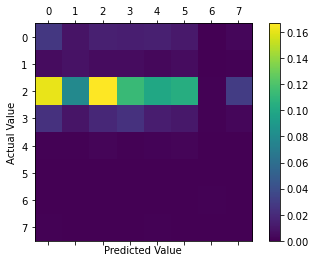

In [86]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat)
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
fig.colorbar(cax)

### Evaluation and Recommendations  

